In [1]:
# importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime as dt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns




In [2]:
# Reading raw data
data=pd.read_csv("Crashes_Last_Five_Years-original.csv")


In [3]:
#  SEVERITY value count
data['SEVERITY'].value_counts()

Other injury accident      52032
Serious injury accident    21561
Fatal accident              1314
Non injury accident            1
Name: SEVERITY, dtype: int64

In [4]:
# delete record with severity = "Non injury accident"
condition= data['SEVERITY']=='Non injury accident'
data.drop(data[condition].index,inplace=True)


In [5]:
data['SEVERITY'].value_counts()

Other injury accident      52032
Serious injury accident    21561
Fatal accident              1314
Name: SEVERITY, dtype: int64

In [6]:
data.head()

,OBJECTID,ACCIDENT_NO,ABS_CODE,ACCIDENT_STATUS,ACCIDENT_DATE,ACCIDENT_TIME,ALCOHOLTIME,ACCIDENT_TYPE,DAY_OF_WEEK,DCA_CODE,...,DEG_URBAN_ALL,LGA_NAME_ALL,REGION_NAME_ALL,SRNS,SRNS_ALL,RMA,RMA_ALL,DIVIDED,DIVIDED_ALL,STAT_DIV_NAME
0,3401744,T20130013732,ABS to receive accident,Finished,1/07/2013,18.30.00,Yes,Struck Pedestrian,Monday,PED NEAR SIDE. PED HIT BY VEHICLE FROM THE RIGHT.,...,MELB_URBAN,MELBOURNE,METROPOLITAN NORTH WEST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undiv,Metro
1,3401745,T20130013736,ABS to receive accident,Finished,2/07/2013,16.40.00,No,Collision with vehicle,Tuesday,PARKED VEHICLES ONLY,...,MELB_URBAN,WHITEHORSE,METROPOLITAN SOUTH EAST REGION,NaN,NaN,Arterial Other,"Arterial Other,Local Road",Divided,"Div,Undiv",Metro
2,3401746,T20130013737,ABS to receive accident,Finished,2/07/2013,13.15.00,No,Collision with a fixed object,Tuesday,RIGHT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,...,MELB_URBAN,BRIMBANK,METROPOLITAN NORTH WEST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undiv,Metro
3,3401747,T20130013738,ABS to receive accident,Finished,2/07/2013,16.45.00,No,Collision with a fixed object,Tuesday,RIGHT OFF CARRIAGEWAY INTO OBJECT/PARKED VEHICLE,...,RURAL_VICTORIA,MITCHELL,NORTHERN REGION,M,M,Freeway,Freeway,Divided,Div,Country
4,3401748,T20130013739,ABS to receive accident,Finished,2/07/2013,15.48.00,No,Collision with vehicle,Tuesday,U TURN,...,"MELBOURNE_CBD,MELB_URBAN",MELBOURNE,METROPOLITAN NORTH WEST REGION,NaN,NaN,Local Road,Local Road,Undivided,Undiv,Metro


In [7]:
data.drop(columns=['SRNS_ALL','SRNS'], inplace=True)

In [8]:
# Delete all rows with any missing data

data.dropna(inplace=True)

In [9]:
# #  Convert ACCIDENT_TIME column data to datetime format, 
data["ACCIDENT_TIME"]=pd.to_datetime(data["ACCIDENT_TIME"],format="%H.%M.%S")

# # EXTRACT THE TIME FROM DATETIME
data["ACCIDENT_TIME"]=data["ACCIDENT_TIME"].dt.hour

#  Get only the data for metropolitan Melbourne
metro=data['STAT_DIV_NAME']=='Metro'
data=data[metro]

# Remove items with more than 105 unique values
max_number_of_unique = 105
data = data.loc[:, (data.nunique() <= max_number_of_unique)]

# Remove attributes that directly define the seriousness of the crash, or are irrelevant
data=data.drop(['OTHERINJURY','SERIOUSINJURY','UNKNOWN','NONINJURED',
                'FATALITY',"INJ_OR_FATAL",'POLICE_ATTEND',
                'ACCIDENT_STATUS','ABS_CODE','REGION_NAME',
                "DEG_URBAN_NAME",'DEG_URBAN_ALL','REGION_NAME_ALL',
                'RMA','DIVIDED','STAT_DIV_NAME','LGA_NAME_ALL','DCA_CODE','MALES','FEMALES','TOTAL_PERSONS','PASSENGER'], axis=1)

Other injury accident      36817
Serious injury accident    13701
Fatal accident               608
Name: SEVERITY, dtype: int64


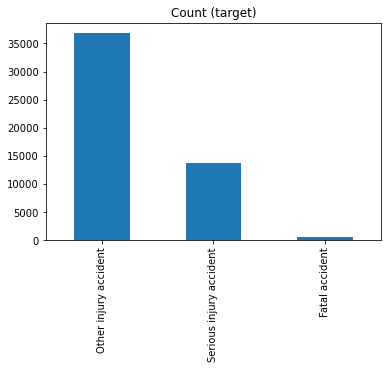

In [10]:
# Check value counts for target classes

print(data['SEVERITY'].value_counts())
data.SEVERITY.value_counts().plot(kind='bar', title='Count (target)');

In [11]:
# Combilne severity category 'Fatal accident' with category 'Serious injury accident' , as a result there will be just two categories,
# 0 represents "Other injury accident" and 1 represents "Serious injury accident",

data['SEVERITY'].replace("Fatal accident",'Serious injury accident',inplace=True)

Other injury accident      36817
Serious injury accident    14309
Name: SEVERITY, dtype: int64


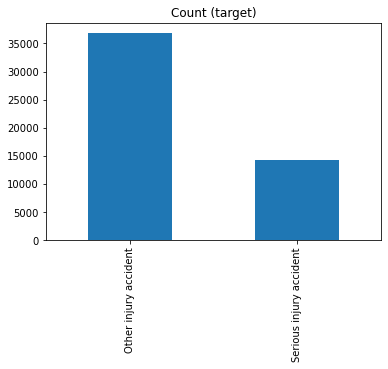

In [12]:
# Check value counts for target classes

print(data['SEVERITY'].value_counts())
data.SEVERITY.value_counts().plot(kind='bar', title='Count (target)');

In [13]:
# data will require resembling due to imbalance, this will be done after label encoding

Random under-sampling:
Other injury accident      14309
Serious injury accident    14309
Name: SEVERITY, dtype: int64


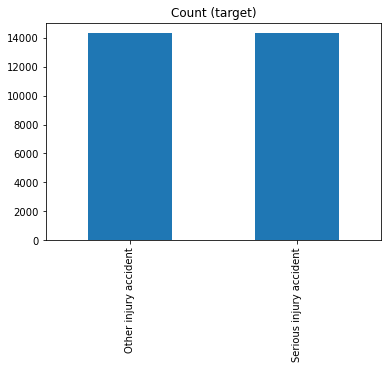

In [14]:
# Resembling Under-Sampling
# Class count
count_class_0, count_class_1 = data.SEVERITY.value_counts()

# Divide by class
data_class_0 = data[data['SEVERITY'] == 'Other injury accident']
data_class_1 = data[data['SEVERITY'] == 'Serious injury accident']



# Random under-sampling
data_class_0_under = data_class_0.sample(count_class_1)
data = pd.concat([data_class_0_under, data_class_1], axis=0)

print('Random under-sampling:')
print(data.SEVERITY.value_counts())

data.SEVERITY.value_counts().plot(kind='bar', title='Count (target)');

In [15]:
# # Apply LabelEncoder to all columns with non numerical values

le=LabelEncoder()
for col in data.columns:
    if data[col].dtype == 'object' and col !='ACCIDENT_TIME':
        data[col]=data[col].astype('str')
        data[col]=le.fit_transform(data[col])

In [16]:
# Separating features and target 
target_col='SEVERITY'
X=data.loc[:,data.columns != target_col]
y=data.loc[:,target_col]

[0.14772351 0.01220934 0.02671303 0.1206987  0.01379287 0.04752444
 0.03650615 0.09385476 0.01409529 0.01359765 0.16557413 0.00853772
 0.0269722  0.00982325 0.00185075 0.01017816 0.00285103 0.00462133
 0.00712057 0.01260016 0.0306591  0.00849878 0.00871541 0.02146358
 0.00737507 0.0292753  0.0087316  0.00381076 0.06922875 0.03539662]


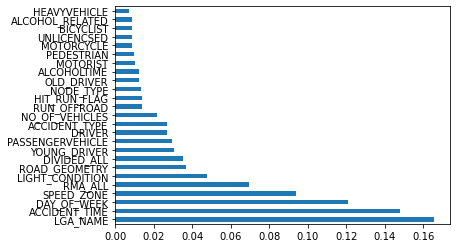

In [17]:
# Selecting best 25 best features for analysis

model=ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances=pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')
plt.show()

In [18]:
features=data.loc[:,feat_importances.nlargest(25).index]
features

,LGA_NAME,ACCIDENT_TIME,DAY_OF_WEEK,SPEED_ZONE,RMA_ALL,LIGHT_CONDITION,ROAD_GEOMETRY,DIVIDED_ALL,YOUNG_DRIVER,PASSENGERVEHICLE,...,NODE_TYPE,OLD_DRIVER,ALCOHOLTIME,MOTORIST,PEDESTRIAN,MOTORCYCLE,UNLICENCSED,BICYCLIST,ALCOHOL_RELATED,HEAVYVEHICLE
70998,20,18,4,4,18,4,3,2,1,2,...,1,0,1,0,0,0,0,0,0,0
45443,20,16,3,8,9,4,3,0,0,2,...,1,0,1,0,0,0,0,0,0,0
56907,24,19,4,4,18,2,6,2,0,2,...,0,1,1,0,0,0,0,0,0,0
44402,14,8,1,6,7,6,0,0,1,2,...,0,0,0,0,0,0,0,0,0,0
35825,4,7,5,6,0,4,3,0,2,3,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74887,8,7,6,5,5,4,3,2,1,1,...,1,0,0,0,0,0,0,0,0,0
74890,31,12,5,0,5,4,3,2,0,1,...,1,0,0,0,0,0,0,0,0,0
74892,19,14,6,8,7,4,6,1,0,1,...,0,1,0,0,0,0,0,0,0,1
74900,31,11,0,5,5,4,3,2,1,4,...,1,0,0,0,0,0,0,0,0,0


In [19]:
# Defining accuracy and confiusion matrix functions

def print_accuracy(classifier):
    print("Train set Accuracy: ", metrics.accuracy_score(y_train, classifier.predict(X_train)))
    print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

def print_confusion(classifier):
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(classifier, X_test, y_test,
                                     display_labels=class_categories,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

In [20]:
#  Normalizing data
scaler = StandardScaler()
features=scaler.fit_transform(features)

In [21]:
#  Splitting the database to train and test sections
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.30)

# targer class categories
class_categories=data["SEVERITY"].unique()

Train set Accuracy:  0.6293430511182109
Test set Accuracy:  0.638248311204286
Confusion matrix, without normalization
[[2848 1560]
 [1546 2632]]
Normalized confusion matrix
[[0.646098   0.353902  ]
 [0.37003351 0.62996649]]


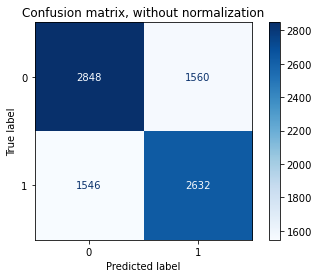

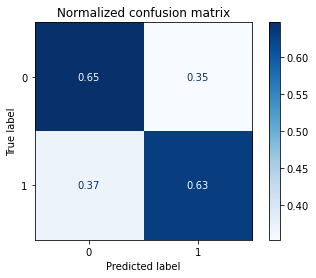

In [22]:
# Using logistic Regression classifier
lr=LogisticRegression(max_iter=4000, tol=0.0001).fit(X_train, y_train,)
yhat = lr.predict(X_test)

print_accuracy(lr)
print_confusion(lr)

Train set Accuracy:  0.6320387380191693
Test set Accuracy:  0.6383647798742138
Confusion matrix, without normalization
[[2997 1411]
 [1694 2484]]
Normalized confusion matrix
[[0.67990018 0.32009982]
 [0.40545716 0.59454284]]


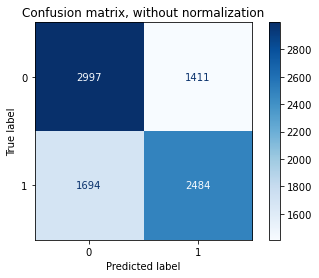

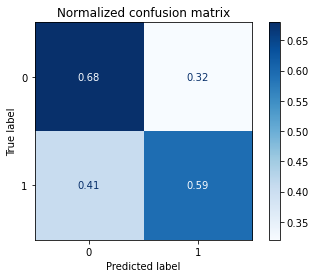

In [23]:
kn = KNeighborsClassifier(n_neighbors=80,weights='uniform').fit(X_train, y_train)
yhat = kn.predict(X_test)

print_accuracy(kn)
print_confusion(kn)

Train set Accuracy:  0.9973043130990416
Test set Accuracy:  0.6180992313067785
Confusion matrix, without normalization
[[2709 1699]
 [1580 2598]]
Normalized confusion matrix
[[0.61456443 0.38543557]
 [0.37817137 0.62182863]]


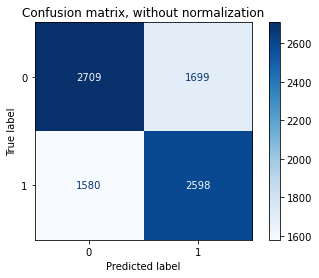

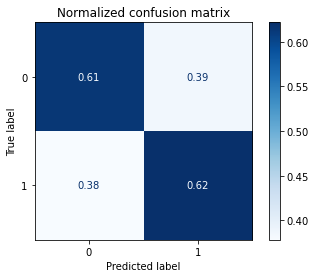

In [24]:
# Using Random forest classifier
rfc = RandomForestClassifier().fit(X_train, y_train)
yhat = rfc.predict(X_test)

print_accuracy(rfc)
print_confusion(rfc)